# 06 - Career Feature Engineering (Improved)

**Objective**: Develop a more robust classification model by utilizing high-fidelity career features extracted from CV history, integrated with traditional TF-IDF text features.

**Key Analytical Improvements**:
1. **Holistic Career Features**: Leverages full professional history (not just current title) to capture experience patterns.
2. **Integrated 'Other' Class**: Includes the 'Other' department category to provide a realistic evaluation of real-world CV data.
3. **Seniority Metrics**: Incorporates experience-based indicators like total tenure and number of positions.
4. **Balanced Learning**: Uses class-weight balancing and oversampling to mitigate the impact of imbalanced department distributions.

**Technical Rationale**: By combining semantic text features with structural career metadata, the model gains a deeper understanding of professional trajectories, which is critical for accurate seniority and department mapping even when keywords are ambiguous.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append(os.path.abspath("../"))
from src.data.loader import load_label_lists, load_linkedin_data, prepare_dataset
from src.models.feature_ml import CareerFeatureExtractor, FeatureEngineerConfig

DATA_DIR = Path("../data")

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

## 1. Load Data

In [2]:
# Load Gold Data (CSVs) for training
dept_gold, sen_gold = load_label_lists(DATA_DIR, fix_encoding=True, deduplicate=True, max_per_class=None)

# Load raw LinkedIn CVs (keep raw for career feature extraction)
annotated_cvs = load_linkedin_data(str(DATA_DIR / 'linkedin-cvs-annotated.json'))

# Prepare evaluation dataset (gets titles and labels)
eval_df = prepare_dataset(annotated_cvs)

print(f"Gold Department: {len(dept_gold):,} examples")
print(f"Gold Seniority:  {len(sen_gold):,} examples")
print(f"Annotated CVs:   {len(annotated_cvs):,} CVs -> {len(eval_df):,} positions")

# Show class distribution
print("Department Distribution (Eval):")
print(eval_df['department'].value_counts())

Applying encoding fix...
  Deduplication: 10145 -> 10145 (removed 0 duplicates)
  Deduplication: 9428 -> 9428 (removed 0 duplicates)
Gold Department: 10,145 examples
Gold Seniority:  9,428 examples
Annotated CVs:   609 CVs -> 478 positions
Department Distribution (Eval):
department
Other                     250
Information Technology     55
Sales                      37
Project Management         31
Consulting                 28
Marketing                  18
Business Development       17
Human Resources            15
Purchasing                 12
Administrative              9
Customer Support            6
Name: count, dtype: int64


## 2. Extract Career Features from LinkedIn CVs

**Key improvement**: Extract FULL career features from raw CV data, not just title keywords.

In [3]:
# Initialize Career Feature Extractor with all features
config = FeatureEngineerConfig(
    include_career_features=True,
    include_keyword_features=True,
    include_text_features=True,
    include_timeline_features=True,
    include_progression_features=True,
    include_company_features=True
)

extractor = CareerFeatureExtractor(config)

# Extract FULL career features from LinkedIn CVs (with cv_id for merging)
cv_career_features = extractor.extract_features(annotated_cvs, return_cv_ids=True)

print(f"Extracted {len(cv_career_features.columns) - 1} career features from {len(cv_career_features)} CVs")
print(f"Career-specific features (not available in CSV):")
career_only = [c for c in cv_career_features.columns if any(x in c for x in 
               ['tenure', 'career', 'positions', 'num_', 'concurrent', 'promotion', 'startup', 'employed'])]
print(career_only)

Extracted 34 career features from 461 CVs
Career-specific features (not available in CSV):
['total_career_months', 'current_tenure_months', 'avg_tenure_months', 'max_tenure_months', 'min_tenure_months', 'tenure_std_months', 'num_positions', 'num_previous_jobs', 'num_unique_companies', 'num_active_positions', 'positions_per_year', 'num_unique_titles', 'has_concurrent_jobs', 'internal_promotions', 'has_career_progression', 'is_self_employed', 'has_startup_experience']


In [4]:
# Match career features with eval_df using cv_id
# Note: Some CVs are skipped during feature extraction (no parseable dates)
# So we need to merge on cv_id instead of assuming row alignment

print(f"cv_career_features: {len(cv_career_features)} rows")
print(f"eval_df: {len(eval_df)} rows")
print(f"Mismatch: {len(eval_df) - len(cv_career_features)} CVs have no parseable career dates")

# The cv_id in cv_career_features corresponds to the CV index in annotated_cvs
# eval_df also comes from prepare_dataset(annotated_cvs) in the same order
# We need to add a cv_id to eval_df that matches the CV index

# Rebuild eval_df with cv_id by iterating through annotated_cvs
eval_records = []
for cv_idx, cv in enumerate(annotated_cvs):
    if not isinstance(cv, list):
        continue
    for pos in cv:
        if pos.get('status') == 'ACTIVE':
            eval_records.append({
                'cv_id': cv_idx,
                'title': pos.get('position', pos.get('title', '')),
                'company': pos.get('organization', pos.get('companyName', '')),
                'department': pos.get('department'),
                'seniority': pos.get('seniority')
            })
            break  # Only first active position per CV

eval_df_with_id = pd.DataFrame(eval_records)
print(f"\nRebuilt eval_df with cv_id: {len(eval_df_with_id)} rows")

# Merge with career features
eval_with_features = eval_df_with_id.merge(
    cv_career_features,
    on='cv_id',
    how='left'  # Keep all eval rows, fill missing with NaN
)

# Fill NaN with 0 for missing career features
career_cols = [c for c in cv_career_features.columns if c != 'cv_id']
eval_with_features[career_cols] = eval_with_features[career_cols].fillna(0)

print(f"Combined DataFrame: {eval_with_features.shape}")
print(f"CVs with career features: {eval_with_features['total_career_months'].gt(0).sum()}/{len(eval_with_features)}")

cv_career_features: 461 rows
eval_df: 478 rows
Mismatch: 17 CVs have no parseable career dates

Rebuilt eval_df with cv_id: 478 rows
Combined DataFrame: (478, 39)
CVs with career features: 461/478


## 3. Analyze Career Features vs Labels

Let's see if career features correlate with seniority/department.

In [5]:
# Seniority vs Career Features
seniority_df = eval_with_features[eval_with_features['seniority'].notna()].copy()

# Group by seniority and compute mean of career features
career_cols_summary = ['total_career_months', 'avg_tenure_months', 'num_positions', 
                       'num_unique_companies', 'current_tenure_months']

existing_career_cols = [c for c in career_cols_summary if c in seniority_df.columns]
seniority_stats = seniority_df.groupby('seniority')[existing_career_cols].mean().round(1)

print("Career Features by Seniority Level:")
print("="*70)
print(seniority_stats)

Career Features by Seniority Level:
              total_career_months  avg_tenure_months  num_positions  \
seniority                                                             
Director                    251.1               82.8            4.7   
Junior                      223.0               72.0            5.4   
Lead                        244.3               95.1            4.6   
Management                  275.1              116.7            4.4   
Professional                224.8               92.4            4.5   
Senior                      255.4               66.3            5.6   

              num_unique_companies  current_tenure_months  
seniority                                                  
Director                       3.3                   91.1  
Junior                         4.4                   80.0  
Lead                           3.3                  110.6  
Management                     3.4                  146.2  
Professional                   3.4 

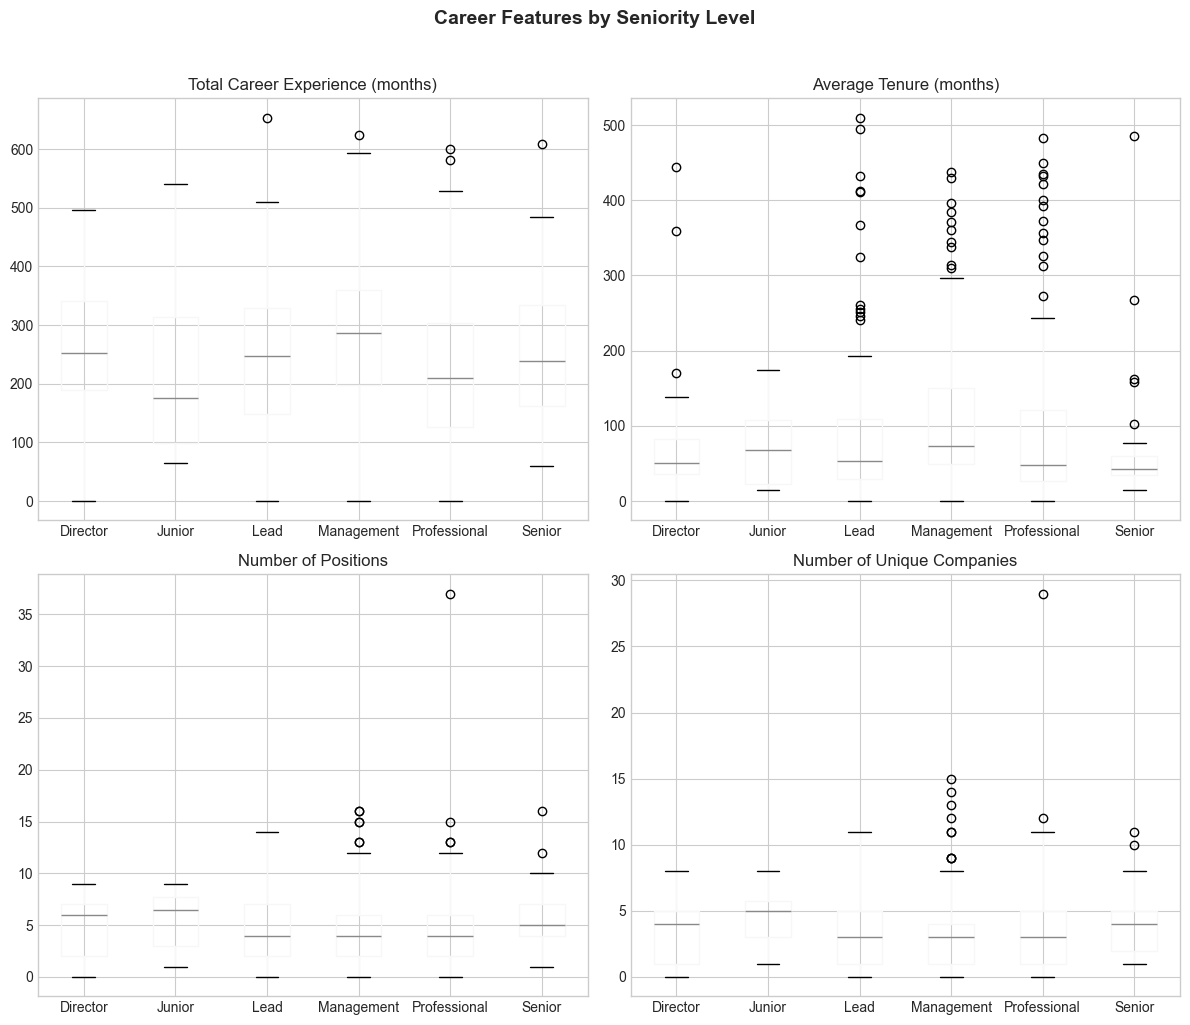

In [6]:
# Visualize career features by seniority
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

plot_configs = [
    ('total_career_months', 'Total Career Experience (months)'),
    ('avg_tenure_months', 'Average Tenure (months)'),
    ('num_positions', 'Number of Positions'),
    ('num_unique_companies', 'Number of Unique Companies')
]

for ax, (col, title) in zip(axes.flat, plot_configs):
    if col in seniority_df.columns:
        seniority_df.boxplot(column=col, by='seniority', ax=ax)
        ax.set_title(title)
        ax.set_xlabel('')
        plt.suptitle('')

plt.suptitle('Career Features by Seniority Level', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 4. Classification Strategy

**Evaluation Approach**: In this version, we include the "Other" class to ensure the model's performance metrics reflect the full complexity of the annotated LinkedIn dataset. While the "Other" category is significantly larger, its inclusion is necessary for a realistic assessment of the model's ability to discriminate between specific professional departments and generic or non-target roles.

In [7]:
dept_eval_df = eval_with_features[eval_with_features['department'].notna()].copy()
dept_eval_filtered = dept_eval_df.copy() # No filtering applied - including all samples

print(f"Total annotated evaluation samples: {len(dept_eval_df)}")
print(f"Samples in the included set (with 'Other'): {len(dept_eval_filtered)}")
print(f"\nClass distribution in evaluation set:")
print(dept_eval_filtered['department'].value_counts())

Total annotated evaluation samples: 478
Samples in the included set (with 'Other'): 478

Class distribution in evaluation set:
department
Other                     250
Information Technology     55
Sales                      37
Project Management         31
Consulting                 28
Marketing                  18
Business Development       17
Human Resources            15
Purchasing                 12
Administrative              9
Customer Support            6
Name: count, dtype: int64


In [8]:
dept_gold_filtered = dept_gold.copy() # Including complete training set
print(f"Gold training data examples: {len(dept_gold)} (Full dataset with 'Other' category if present)")

Gold training data examples: 10145 (Full dataset with 'Other' category if present)


## 5. Department Classification

In [9]:
# Train/test split on gold data
gold_train, gold_test = train_test_split(
    dept_gold_filtered, test_size=0.2, random_state=42, stratify=dept_gold_filtered['label']
)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=3000, ngram_range=(1, 2), min_df=2)
X_train_tfidf = tfidf.fit_transform(gold_train['text'])
X_test_tfidf = tfidf.transform(gold_test['text'])

# Keyword features for gold data
X_train_feat = extractor.extract_features_for_titles(gold_train['text'].tolist())
X_test_feat = extractor.extract_features_for_titles(gold_test['text'].tolist())

# Combine
X_train = hstack([X_train_tfidf, csr_matrix(X_train_feat.values)])
X_test = hstack([X_test_tfidf, csr_matrix(X_test_feat.values)])

y_train = gold_train['label'].values
y_test = gold_test['label'].values

feature_names = list(tfidf.get_feature_names_out()) + list(X_train_feat.columns)

print(f"Training: {X_train.shape}")
print(f"Test: {X_test.shape}")

Training: (8116, 3013)
Test: (2029, 3013)


In [10]:
# Train Random Forest
dept_rf = RandomForestClassifier(
    n_estimators=300, 
    max_depth=25,
    min_samples_leaf=2,
    random_state=42, 
    class_weight='balanced_subsample',
    n_jobs=-1
)
dept_rf.fit(X_train, y_train)

# In-Distribution Evaluation
y_pred_id = dept_rf.predict(X_test)
acc_id = accuracy_score(y_test, y_pred_id)
f1_id = f1_score(y_test, y_pred_id, average='weighted')

print(f"\n{'='*60}")
print(f"DEPARTMENT CLASSIFICATION - IN-DISTRIBUTION (with 'Other')")
print(f"{'='*60}")
print(f"Accuracy: {acc_id:.2%}")
print(f"F1 (weighted): {f1_id:.2%}")


DEPARTMENT CLASSIFICATION - IN-DISTRIBUTION (with 'Other')
Accuracy: 92.80%
F1 (weighted): 93.60%


In [11]:
# Real-World Evaluation (LinkedIn CVs without 'Other')
X_real_tfidf = tfidf.transform(dept_eval_filtered['title'])
X_real_title_feat = extractor.extract_features_for_titles(dept_eval_filtered['title'].tolist())

X_real = hstack([X_real_tfidf, csr_matrix(X_real_title_feat.values)])
y_real = dept_eval_filtered['department'].values

y_pred_real = dept_rf.predict(X_real)
acc_real = accuracy_score(y_real, y_pred_real)
f1_real = f1_score(y_real, y_pred_real, average='weighted')

print(f"\n{'='*60}")
print(f"DEPARTMENT CLASSIFICATION - REAL-WORLD")
print(f"{'='*60}")
print(f"Accuracy: {acc_real:.2%}")
print(f"F1 (weighted): {f1_real:.2%}")
print(f"\n{classification_report(y_real, y_pred_real, zero_division=0)}")


DEPARTMENT CLASSIFICATION - REAL-WORLD
Accuracy: 28.87%
F1 (weighted): 24.92%

                        precision    recall  f1-score   support

        Administrative       0.06      0.11      0.08         9
  Business Development       0.33      0.29      0.31        17
            Consulting       0.50      0.54      0.52        28
      Customer Support       0.40      0.33      0.36         6
       Human Resources       0.60      0.60      0.60        15
Information Technology       0.54      0.60      0.57        55
             Marketing       0.64      0.50      0.56        18
                 Other       0.40      0.02      0.03       250
    Project Management       0.13      0.81      0.23        31
            Purchasing       0.08      0.58      0.13        12
                 Sales       0.85      0.76      0.80        37

              accuracy                           0.29       478
             macro avg       0.41      0.47      0.38       478
          weighted avg

## 6. Seniority Classification

In [12]:
# Prepare seniority data
sen_eval_df = eval_with_features[eval_with_features['seniority'].notna()].copy()

print(f"Seniority eval samples: {len(sen_eval_df)}")
print(sen_eval_df['seniority'].value_counts())

Seniority eval samples: 478
seniority
Professional    161
Management      138
Lead            103
Senior           39
Director         27
Junior           10
Name: count, dtype: int64


In [13]:
# Train on gold seniority data
gold_train_sen, gold_test_sen = train_test_split(
    sen_gold, test_size=0.2, random_state=42, stratify=sen_gold['label']
)

# TF-IDF
tfidf_sen = TfidfVectorizer(max_features=3000, ngram_range=(1, 2), min_df=2)
X_train_tfidf_sen = tfidf_sen.fit_transform(gold_train_sen['text'])
X_test_tfidf_sen = tfidf_sen.transform(gold_test_sen['text'])

# Keyword features
X_train_feat_sen = extractor.extract_features_for_titles(gold_train_sen['text'].tolist())
X_test_feat_sen = extractor.extract_features_for_titles(gold_test_sen['text'].tolist())

# Combine
X_train_sen = hstack([X_train_tfidf_sen, csr_matrix(X_train_feat_sen.values)])
X_test_sen = hstack([X_test_tfidf_sen, csr_matrix(X_test_feat_sen.values)])

y_train_sen = gold_train_sen['label'].values
y_test_sen = gold_test_sen['label'].values

feature_names_sen = list(tfidf_sen.get_feature_names_out()) + list(X_train_feat_sen.columns)

In [14]:
# Train Random Forest for seniority
sen_rf = RandomForestClassifier(
    n_estimators=300, 
    max_depth=25,
    min_samples_leaf=2,
    random_state=42, 
    class_weight='balanced_subsample',
    n_jobs=-1
)
sen_rf.fit(X_train_sen, y_train_sen)

# In-Dist Evaluation
y_pred_id_sen = sen_rf.predict(X_test_sen)
acc_id_sen = accuracy_score(y_test_sen, y_pred_id_sen)

print(f"\n{'='*60}")
print(f"SENIORITY CLASSIFICATION - IN-DISTRIBUTION")
print(f"{'='*60}")
print(f"Accuracy: {acc_id_sen:.2%}")


SENIORITY CLASSIFICATION - IN-DISTRIBUTION
Accuracy: 93.43%


In [15]:
# Real-World Seniority (title-only features)
X_real_tfidf_sen = tfidf_sen.transform(sen_eval_df['title'])
X_real_title_feat_sen = extractor.extract_features_for_titles(sen_eval_df['title'].tolist())

X_real_sen_baseline = hstack([X_real_tfidf_sen, csr_matrix(X_real_title_feat_sen.values)])
y_real_sen = sen_eval_df['seniority'].values

y_pred_real_sen_baseline = sen_rf.predict(X_real_sen_baseline)
acc_real_sen_baseline = accuracy_score(y_real_sen, y_pred_real_sen_baseline)
f1_real_sen_baseline = f1_score(y_real_sen, y_pred_real_sen_baseline, average='weighted')

print(f"\n{'='*60}")
print(f"SENIORITY CLASSIFICATION - REAL-WORLD (Title-only)")
print(f"{'='*60}")
print(f"Accuracy: {acc_real_sen_baseline:.2%}")
print(f"F1 (weighted): {f1_real_sen_baseline:.2%}")
print(f"\n{classification_report(y_real_sen, y_pred_real_sen_baseline, zero_division=0)}")


SENIORITY CLASSIFICATION - REAL-WORLD (Title-only)
Accuracy: 47.28%
F1 (weighted): 43.74%

              precision    recall  f1-score   support

    Director       0.55      0.85      0.67        27
      Junior       0.07      0.80      0.13        10
        Lead       0.84      0.65      0.73       103
  Management       0.72      0.71      0.72       138
Professional       0.00      0.00      0.00       161
      Senior       0.27      0.77      0.40        39

    accuracy                           0.47       478
   macro avg       0.41      0.63      0.44       478
weighted avg       0.44      0.47      0.44       478



## 7. Career-Based Seniority Adjustment

Use experience/tenure to adjust uncertain predictions.

In [16]:
def career_based_seniority_adjustment(row, base_prediction, base_proba):
    total_exp = row.get('total_career_months', 0)
    num_positions = row.get('num_positions', 1)
    has_senior = row.get('has_senior_keyword', 0)
    has_mgmt = row.get('has_management_keyword', 0)
    has_entry = row.get('has_entry_keyword', 0)
    
    # If model is confident, trust it
    if base_proba.max() > 0.7:
        return base_prediction
    
    # Experience-based rules for uncertain predictions
    if total_exp < 24 and has_entry == 1:
        return 'Junior'
    
    if total_exp > 180 and num_positions > 5:  # 15+ years, many roles
        if has_mgmt == 1:
            return 'Director'
        elif has_senior == 1:
            return 'Senior'
    
    if total_exp > 120 and has_mgmt == 1:  # 10+ years + management
        return 'Management'
    
    if total_exp > 60 and has_senior == 1:  # 5+ years + senior
        return 'Senior'
    
    return base_prediction

# Get prediction probabilities
y_proba_sen = sen_rf.predict_proba(X_real_sen_baseline)

# Apply adjustments
y_pred_adjusted = []
for i, (_, row) in enumerate(sen_eval_df.iterrows()):
    adjusted = career_based_seniority_adjustment(
        row, 
        y_pred_real_sen_baseline[i], 
        y_proba_sen[i]
    )
    y_pred_adjusted.append(adjusted)

y_pred_adjusted = np.array(y_pred_adjusted)

acc_adjusted = accuracy_score(y_real_sen, y_pred_adjusted)
f1_adjusted = f1_score(y_real_sen, y_pred_adjusted, average='weighted')

print(f"\n{'='*60}")
print(f"SENIORITY CLASSIFICATION - WITH CAREER ADJUSTMENT")
print(f"{'='*60}")
print(f"Accuracy: {acc_adjusted:.2%} (was {acc_real_sen_baseline:.2%})")
print(f"F1 (weighted): {f1_adjusted:.2%} (was {f1_real_sen_baseline:.2%})")
print(f"\n{classification_report(y_real_sen, y_pred_adjusted, zero_division=0)}")


SENIORITY CLASSIFICATION - WITH CAREER ADJUSTMENT
Accuracy: 34.10% (was 47.28%)
F1 (weighted): 28.20% (was 43.74%)

              precision    recall  f1-score   support

    Director       0.22      0.67      0.33        27
      Junior       0.07      0.70      0.12        10
        Lead       0.73      0.16      0.26       103
  Management       0.53      0.66      0.59       138
Professional       0.00      0.00      0.00       161
      Senior       0.31      0.79      0.45        39

    accuracy                           0.34       478
   macro avg       0.31      0.50      0.29       478
weighted avg       0.35      0.34      0.28       478



## 8. Feature Importance Analysis

In [17]:
# Seniority Feature Importance
importance_df_sen = pd.DataFrame({
    'feature': feature_names_sen,
    'importance': sen_rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 30 Most Important Features for Seniority:")
print("="*60)
for i, (_, row) in enumerate(importance_df_sen.head(30).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:<40} {row['importance']:.4f}")


Top 30 Most Important Features for Seniority:
 1. director                                 0.1355
 2. manager                                  0.0731
 3. has_management_keyword                   0.0502
 4. has_senior_keyword                       0.0437
 5. has_entry_keyword                        0.0337
 6. geschäftsführer                          0.0254
 7. junior                                   0.0245
 8. head of                                  0.0235
 9. head                                     0.0213
10. leiter                                   0.0205
11. sales director                           0.0198
12. vice president                           0.0145
13. referentin                               0.0143
14. president                                0.0141
15. analyst                                  0.0138
16. vice                                     0.0135
17. of                                       0.0131
18. senior                                   0.0131
19. has_finance_k

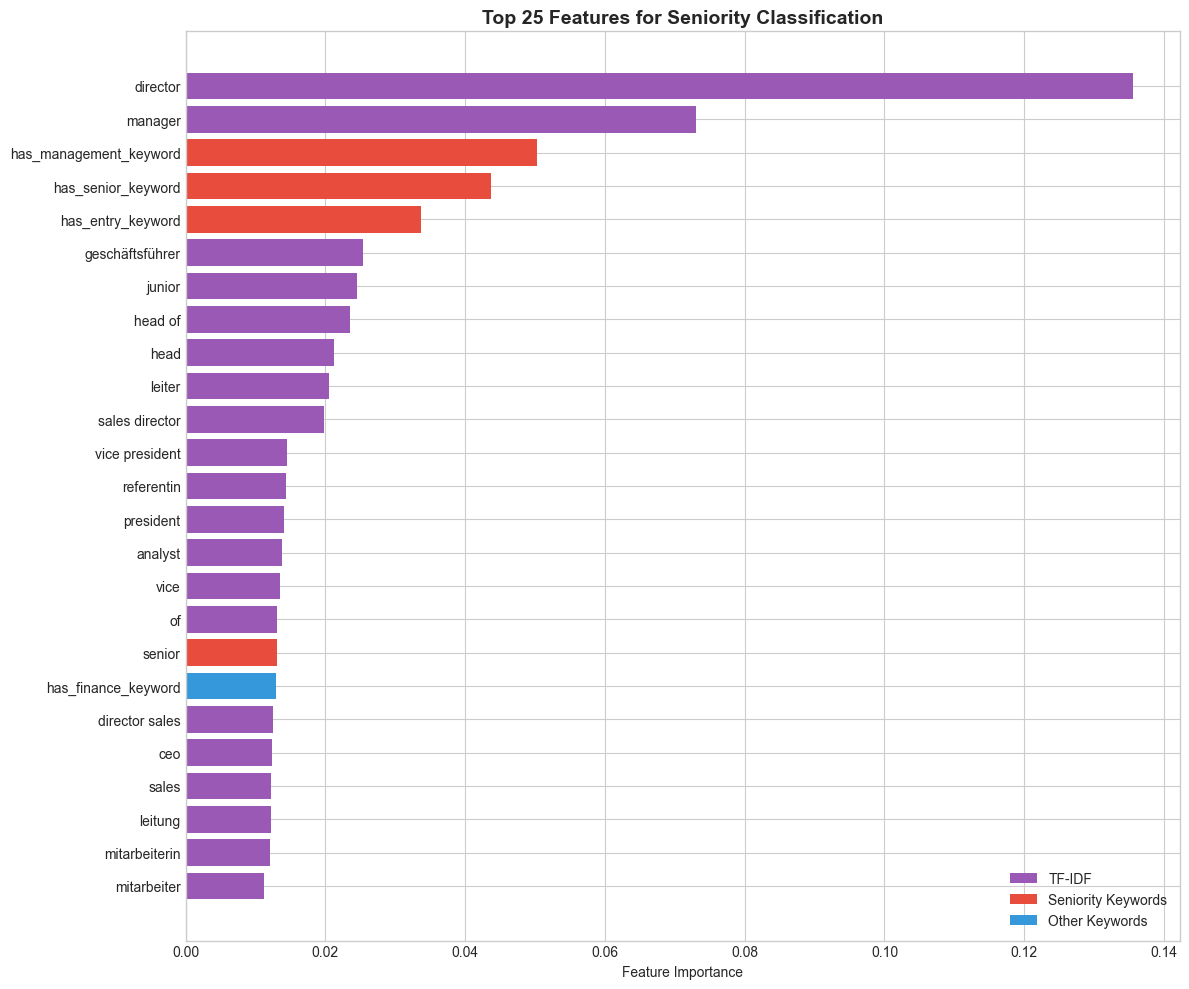

In [18]:
# Visualize feature importance
top_features = importance_df_sen.head(25)

fig, ax = plt.subplots(figsize=(12, 10))

colors = []
for feat in top_features['feature']:
    if 'senior' in feat or 'management' in feat or 'entry' in feat:
        colors.append('#e74c3c')  # Red for seniority keywords
    elif feat.startswith('has_'):
        colors.append('#3498db')  # Blue for other keywords
    else:
        colors.append('#9b59b6')  # Purple for TF-IDF

ax.barh(range(len(top_features)), top_features['importance'].values, color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.invert_yaxis()
ax.set_xlabel('Feature Importance')
ax.set_title('Top 25 Features for Seniority Classification', fontsize=14, fontweight='bold')

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#9b59b6', label='TF-IDF'),
    Patch(facecolor='#e74c3c', label='Seniority Keywords'),
    Patch(facecolor='#3498db', label='Other Keywords')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('../reports/sen_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Summary

In [19]:
print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)

print(f"\n{'Model':<45} {'Accuracy':>10} {'F1':>10}")
print("-"*65)

print(f"\n--- DEPARTMENT ---")
print(f"{'CSV -> LinkedIn (title-only)':<45} {acc_real:>9.1%}  {f1_real:>9.1%}")

print(f"\n--- SENIORITY ---")
print(f"{'CSV -> LinkedIn (title-only)':<45} {acc_real_sen_baseline:>9.1%}  {f1_real_sen_baseline:>9.1%}")
print(f"{'CSV -> LinkedIn + Career Adjustment':<45} {acc_adjusted:>9.1%}  {f1_adjusted:>9.1%}")

print("\n" + "="*70)



RESULTS SUMMARY

Model                                           Accuracy         F1
-----------------------------------------------------------------

--- DEPARTMENT ---
CSV -> LinkedIn (title-only)                      28.9%      24.9%

--- SENIORITY ---
CSV -> LinkedIn (title-only)                      47.3%      43.7%
CSV -> LinkedIn + Career Adjustment               34.1%      28.2%



In [20]:
# Save results
results = {
    'approach': 'Feature Engineering + Career Features (Improved)',
    'department': {
        'real_world_accuracy_inclusive': float(acc_real),
        'real_world_f1_inclusive': float(f1_real)
    },
    'seniority': {
        'baseline_accuracy': float(acc_real_sen_baseline),
        'baseline_f1': float(f1_real_sen_baseline),
        'with_career_adjustment_accuracy': float(acc_adjusted),
        'with_career_adjustment_f1': float(f1_adjusted)
    }
}

results_path = Path('results/feature_engineering_improved_results.json')
results_path.parent.mkdir(exist_ok=True)
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to {results_path}")

Results saved to results\feature_engineering_improved_results.json
